In [1]:
import torch
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from model.model_inference_v2 import Tacotron2
from vocoder.model.waveglow import WaveGlow
from vocoder.denoiser_librosa import Denoiser
from korean_text.korean_cleaner_cls import KoreanCleaner

from text import text_to_sequence, sequence_to_text
from utils.util import mode, to_var, to_arr

from demo_proc import _convert_to_pcm16

# 학습된 모델 로드

### 모델 다운로드 방법

> 출처 : [AI허브](https://www.aihub.or.kr/aihubdata/data/list.do?pageIndex=1&currMenu=115&topMenu=100&dataSetSn=&srchdataClCode=DATACL001&srchOrder=&SrchdataClCode=DATACL002&searchKeyword=%ED%95%9C%EA%B5%AD%EC%96%B4+%EB%B0%A9%EC%96%B8&srchDataRealmCode=REALM002&srchDataTy=DATA004)

![](imgs/01.png)

1. AI허브 회원가입 - 데이터셋 상세 페이지 - 활용 AI 모델 및 코드 - AI 모델 다운로드

2. 압축 해제 - 03.AI모델 - 1. Binary File - 음성합성 - acoustic.ckpt, vocoder.ckpt

### 모델 종류

- 강원도 2
- 경상도 1
- 전라도 1
- 제주도 2
- 충청도 1

In [67]:
device = 'cpu' # cuda

# Tacotron2
ckpt_dict = torch.load('logs/model/acoustic.ckpt', map_location=torch.device(device))
model = Tacotron2()
model.load_state_dict(ckpt_dict['model'])
model = model.eval()

# Vocoder
ckpt_dict = torch.load('logs/model/vocoder.ckpt', map_location=torch.device(device))
vocoder = WaveGlow()
vocoder.load_state_dict(ckpt_dict['model'])
vocoder = vocoder.remove_weightnorm(vocoder)
vocoder.eval()
denoiser = Denoiser(vocoder, 0.1)

korean_cleaner = KoreanCleaner()

# 텍스트 전처리

In [68]:
text = '헬로월드! 유튜브 빵형의 개발도상국에 어서오세요!'

text = korean_cleaner.clean_text(text)

print(text)

헬로월드! 유튜브 빵형의 개발도상국에 어서오세요!


# 텍스트를 시퀀스로 변경

In [69]:
sequence = text_to_sequence(text, ['multi_cleaner'])
sequence = to_var(torch.IntTensor(sequence)[None, :]).long()

print(sequence)

tensor([[137, 143, 166, 124, 146, 130, 152, 166, 122, 156,   3,   8, 130, 155,
         135, 155, 126, 156,   8, 127, 138, 179, 137, 144, 179, 130, 157,   8,
         119, 139, 126, 138, 166, 122, 146, 128, 138, 179, 119, 151, 159, 130,
         143,   8, 130, 142, 128, 142, 130, 146, 128, 143, 130, 150,   3,   0]])


# 추론

Terminated by gate.
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 11, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 17, 17, 18, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 22, 23, 23, 23, 23, 24, 24, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 36, 37, 37, 38, 38, 38, 39, 39, 40, 40, 40, 41, 42, 42, 42, 42, 42, 43, 43, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 48, 48, 48, 49, 49, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55]
['ᄒ', 'ᄒ', 'ᄒ', 'ᄒ', 'ᄒ', 'ᄒ', 'ᄒ', 'ᄒ', 'ᄒ', 'ᄒ', 'ᅦ', 'ᅦ', 'ᅦ', 'ᅦ', 'ᅦ', 'ᅦ', 'ᆯ', 'ᆯ', 'ᆯ', 'ᆯ', 'ᆯ', 'ᄅ', 'ᄅ', 'ᅩ', 'ᅩ', 'ᅩ', 'ᄋ', 'ᄋ', 'ᅯ', 'ᅯ', 'ᅯ', 'ᆯ', 'ᆯ', 'ᆯ', 'ᄃ', 'ᄃ', 'ᄃ', 'ᅳ', 'ᅳ', 'ᅳ', 'ᅳ', 'ᅳ', '!', '!', ' ',

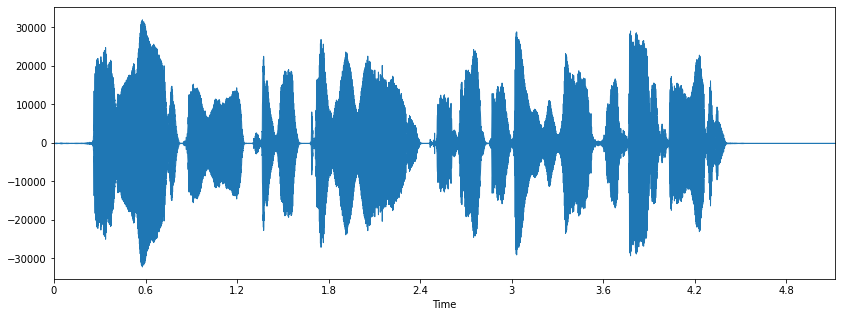

In [70]:
sigma = 0.5
strength = 10
sample_rate = 22050

with torch.no_grad():
    _, mel_outputs_postnet, linear_outputs, _, alignments = model.inference(sequence)
    wav = vocoder.infer(mel_outputs_postnet, sigma=sigma)

    wav *= 32767. / max(0.01, torch.max(torch.abs(wav)))
    wav = wav.squeeze()
    wav = wav.cpu().detach().numpy().astype('float32')

    wav = denoiser(wav, strength=strength)

wav = np.append(wav, np.array([[0.0] * (sample_rate // 2)]))
audio_duration = librosa.get_duration(wav, sample_rate)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(wav, sr=sample_rate)

# 결과 파일 저장

In [71]:
import IPython.display as ipd
import soundfile as sf

wav_file = wav.astype(np.int16)
# sf.write('temp.wav', wav_file, sample_rate)

ipd.Audio(wav_file, rate=sample_rate)